In [1]:
import numpy as np
import os
from scipy.io import loadmat
import random
import cv2
from sklearn.feature_extraction import image
from tensorflow.keras.layers import (Input,Activation, Conv2D, Dropout, Convolution2D,UpSampling2D)
from tensorflow.keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten,Conv2DTranspose,
                  Add,MaxPooling2D,MaxPooling3D, Input, Concatenate,BatchNormalization,LeakyReLU)
from tensorflow.keras.losses import mean_absolute_error
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.optimizers import Adam
import os, math
import matplotlib
import matplotlib.pyplot as plt
import cv2
import argparse
import numpy as np
import tensorflow as tf
import random
from skimage import io, img_as_uint, img_as_ubyte
import tensorflow.keras.backend as K
from tqdm import tqdm
from statistics import mean
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime
from numba import cuda 

In [2]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.2
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [3]:
tf.__version__

'2.2.0'

In [4]:
tf.test.is_gpu_available(cuda_only=True) 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
class data_utils():
    def __init__(self,X_dir,y_dir):
        self.X_dir = X_dir
        self.y_dir = y_dir
        self.train_size =  len(os.listdir(y_dir))
        self.order = np.arange(self.train_size)
        np.random.shuffle(self.order)
        self.X_files = sorted(os.listdir(self.X_dir))
        self.y_files = sorted(os.listdir(self.y_dir))
        self.image_dims = (512,512)

    def append_image(self,data_dir,data_save_path,image_size=None,resize=False,save=True):
      img_list = []
      count = 0
      for img in sorted(os.listdir(data_dir)):
        img_path = os.path.join(data_dir, img)
        image = cv2.imread(img_path)
        img_list.append(image)
        count += 1
        print(np.array(img_list).shape,end='\r')
      if save:
        try:
          np.save(data_save_path, np.array(img_list))
          print('\nsaved....... ', os.path.split(data_save_path)[1], np.array(img_list).shape)
        except:
          print("[WARNING]..Exception Occured ......!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
          print('[INFO] To save image array as numpy file provide location with file name')
      return np.array(img_list)
    
    def load_train_clean(self,data_dir, data_save_dir, file_save_name):
      if os.path.exists(data_save_dir+'/'+file_save_name+'.npy'):
        train_data = np.load(data_save_dir+'/'+file_save_name+'.npy')
        print('Data loaded ........................',file_save_name+'.npy', train_data.shape)
      else:
        train_data = self.append_image(data_dir, data_save_dir, file_save_name)
      return train_data
    
    def load_gt(self,data_dir, data_save_dir, file_save_name):
      if os.path.exists(data_save_dir+'/'+file_save_name+'.npy'):
        final_numpyData = np.load(data_save_dir+'/'+file_save_name+'.npy')
      else:
        for i,pic in enumerate(sorted(os.listdir(data_dir))):
          x = loadmat(data_dir+'/'+pic)
          mat_img = x['cube']
          if(i==0):
            final_numpyData = mat_img
          elif i==1:
            final_numpyData = np.stack([final_numpyData,mat_img])
          else:
            final_numpyData = np.concatenate([final_numpyData, np.expand_dims(mat_img,axis=0)])
        try:
          np.save(data_save_dir+'/'+file_save_name+'.npy',final_numpyData)
          print('successfully saved',data_save_dir+'/'+file_save_name+'.npy',end='\n')
        except Exception as e:
          print("[WARNING]..Exception Occured ......!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
          print('[INFO] To save consolidated numpy file provide file_save_path with file name')
      print('Ground Truth data loaded...........', final_numpyData.shape)
      return final_numpyData

    def create_patches(self,arr,size,stride):
        patch_num = (int((arr.shape[0]-size)/stride)+1)*(int((arr.shape[1]-size)/stride)+1)
        return image.extract_patches_2d(arr, (size,size),max_patches=patch_num)

    def normalize(self,image):
        image = (image / 127.5) - 1
        return image
    
    def load_data_batch(self,batch_size,batch_num,patch_num,make_patch = False,patch_size=256,patch_stride=128,resize_img=True):
        img_list = []
        spec_list = []
        cnt = 0
        start = batch_size*batch_num
        while cnt<batch_size and start+cnt != self.train_size:
            img = self.X_files[self.order[start+cnt]]
            spec = self.y_files[self.order[start+cnt]]
            img_path = os.path.join(self.X_dir, img)
            spec_path = os.path.join(self.y_dir,spec)
            image = cv2.imread(img_path)
            x = loadmat(spec_path)
            spectral = x['cube']
            if resize_img:
                image = resize(image,self.image_dims)
                spectral = resize(spectral, self.image_dims)
            if make_patch:
                X_patches = self.create_patches(image,size=patch_size,stride=patch_stride)
                y_patches = self.create_patches(spectral,size=patch_size,stride=patch_stride)
                for i in range(len(X_patches)):
                    if patch_num == i:
                        return self.normalize(X_patches[i]),self.normalize(y_patches[i])
#                     img_list.append(self.normalize(X_patches[i]))
#                     spec_list.append(self.normalize(y_patches[i]))
            else:
                img_list.append(self.normalize(image))
                spec_list.append(self.normalize(spectral))
            cnt += 1
        X = np.array(img_list)
        y = np.array(spec_list)
        np.random.shuffle(X)
        np.random.shuffle(y)
        return X,y

    def load_random_set(self,batch_size,make_patch=True):
        chosen = random.sample(range(self.train_size),batch_size)
        img_list = []
        cnt = 0
        while cnt<batch_size:
            img = self.X_files[chosen[cnt]]
            img_path = os.path.join(self.X_dir, img)
            image = cv2.imread(img_path)
            image = resize(image,self.image_dims)
            if make_patch:
                patches = self.create_patches(image,size=64,stride=16)
                img_list += patches
            else:
                img_list.append(image)
            cnt += 1
        X = np.array(img_list)
        np.random.shuffle(X)
        return X
    
    def denormalize(self,img):
        img = img*(255/2)
        img = img+(255/2)
        return img
        
    def show_sample(self,rgb,spec,real):
        f, axarr = plt.subplots(2,6)
        #axarr[0,0].imshow(rgb[0])
#         spec = self.denormalize(spec)
#         real = self.denormalize(real)
#         print(spec)
#         print(real)
        axarr[0,0].imshow(spec[0,:,:,5])
        axarr[1,0].imshow(real[0,:,:,5])
        axarr[0,1].imshow(spec[0,:,:,10])
        axarr[1,1].imshow(real[0,:,:,10])
        axarr[0,2].imshow(spec[0,:,:,15])
        axarr[1,2].imshow(real[0,:,:,15])
        axarr[0,3].imshow(spec[0,:,:,20])
        axarr[1,3].imshow(real[0,:,:,20])
        axarr[0,4].imshow(spec[0,:,:,25])
        axarr[1,4].imshow(real[0,:,:,25])
        axarr[0,5].imshow(spec[0,:,:,30])
        axarr[1,5].imshow(real[0,:,:,30])
        plt.show()
        return spec



In [6]:
def mrae_loss(y_pred, y_true):
    difference = K.abs(y_true - y_pred)
    mrae = K.mean(difference)
    return mrae

In [7]:
class Model_PatchGAN():
    def __init__(self,image_size,LAMBDA = 100,patch_size = 70,only_last = 5,g_lr = 2e-4,d_lr=2e-4,beta_1=0.5,block1_channels = 64,block2_channels = 128,block3_channels = 256):
        self.image_size = image_size
        self.lmbda = LAMBDA
        self.hs_size = (image_size[0],image_size[1],31)
        self.only_last = only_last
        #self.generator_loss = generator_loss
        #self.discriminator_loss = discriminator_loss
        #self.gan_loss = gan_loss
        #self.optimizer = optimizer
        self.block1_channels = block1_channels
        self.block2_channels = block2_channels
        self.block3_channels = block3_channels
        self.patch_size = patch_size
        self.loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(g_lr, beta_1=beta_1)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(d_lr, beta_1=beta_1)
        self.checkpoint_dir = './training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        #self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,discriminator_optimizer=self.discriminator_optimizer,generator= generator,discriminator=discriminator)
        self.log_dir="./logs/"
        self.summary_writer = tf.summary.create_file_writer(self.log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    def residual_block(self,ip,channels):
        init = ip
        x = Convolution2D(channels, (3, 3), activation='relu', padding='same')(ip)
        x = Convolution2D(channels, (3, 3), activation='relu', padding='same')(x)
        m = Concatenate(axis=3)([x, init])
        return m
    
    def downsample(self,filters, size, apply_batchnorm=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
        if apply_batchnorm:
            result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.LeakyReLU())
        return result

    def upsample(self,filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.5))
        result.add(tf.keras.layers.ReLU())
        return result

    def UNet_Generator(self):
        inputs = tf.keras.layers.Input(shape=self.image_size)
        OUTPUT_CHANNELS = self.hs_size[-1]
        down_stack = [
            self.downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
            self.downsample(128, 4), # (bs, 64, 64, 128)
            self.downsample(256, 4), # (bs, 32, 32, 256)
            self.downsample(512, 4), # (bs, 16, 16, 512)
            self.downsample(512, 4), # (bs, 8, 8, 512)
            self.downsample(512, 4), # (bs, 4, 4, 512)
            self.downsample(512, 4), # (bs, 2, 2, 512)
            self.downsample(512, 4), # (bs, 1, 1, 512)
        ]

        up_stack = [
            self.upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
            self.upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
            self.upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
            self.upsample(512, 4), # (bs, 16, 16, 1024)
            self.upsample(256, 4), # (bs, 32, 32, 512)
            self.upsample(128, 4), # (bs, 64, 64, 256)
            self.upsample(64, 4), # (bs, 128, 128, 128)
        ]

        initializer = tf.random_normal_initializer(0., 0.02)
        last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,strides=2,padding='same',kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 3)
        x = inputs
        # Downsampling through the model
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])
        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            x = tf.keras.layers.Concatenate()([x, skip])
        x = last(x)
        return tf.keras.Model(inputs=inputs, outputs=x)
    
    def residual_block(self,ip,channels):
        init = ip
        initializer = tf.random_normal_initializer(0., 0.02)
        x = Convolution2D(channels, (3, 3), activation='relu', padding='same',kernel_initializer= initializer)(ip)
        x = Convolution2D(channels, (3, 3), activation='relu', padding='same',kernel_initializer= initializer)(x)
        x = Convolution2D(channels, (3, 3), activation='relu', padding='same',kernel_initializer= initializer)(x)
        x = Convolution2D(channels, (3, 3), activation='linear', padding='same',kernel_initializer= initializer)(x)
        m = Concatenate(axis=3)([x, init])
        return m
    
    def make_generator(self):
        inp = Input(self.image_size)
        initializer = tf.random_normal_initializer(0., 0.02)
        C1 = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu',kernel_initializer = initializer)(inp)
        x = C1
        x = self.residual_block(x,self.block1_channels)
        x = Activation('relu')(x)
        x = self.residual_block(x,self.block2_channels)
        x = Activation('relu')(x)
        x = self.residual_block(x,self.block3_channels)
        x = Activation('relu')(x)
        Cout = Conv2D(31, kernel_size=(3,3), padding='same', activation='relu',kernel_initializer = initializer)(x)
        model = Model(inp, Cout)
        return model
    
    def generator_loss_nolast(self,disc_generated_output, gen_output, target):
        gan_loss = self.loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
        l1_loss = tf.reduce_mean(tf.abs(tf.dtypes.cast(target, tf.float32) - gen_output))
        total_gen_loss = gan_loss + (self.lmbda * l1_loss)
        return total_gen_loss, gan_loss, l1_loss
    
    def generator_loss(self,disc_generated_output_all,disc_generated_output_last, gen_output, target):
        gan_loss = (1/2)*(self.loss_object(tf.ones_like(disc_generated_output_all), disc_generated_output_all) + self.loss_object(tf.ones_like(disc_generated_output_last), disc_generated_output_last))
        l1_loss = tf.reduce_mean(tf.abs(tf.dtypes.cast(target, tf.float32) - gen_output))
        total_gen_loss = gan_loss + (self.lmbda * l1_loss)
        return total_gen_loss, gan_loss, l1_loss
    
    
    def make_discriminator(self,only_last=0):
        in_src_image = Input(shape=self.image_size)
        # target image input
        if only_last:
            in_target_image = Input(shape = (self.image_size[0],self.image_size[1],self.only_last))
        else:
            in_target_image = Input(shape=self.hs_size)
        # concatenate images channel-wise
        merged = Concatenate()([in_src_image, in_target_image])
        # C64
        d = Conv2D(64, (4,4), strides=(2,2), padding='same')(merged)
        d = LeakyReLU(alpha=0.2)(d)
        # C128
        d = Conv2D(128, (4,4), strides=(2,2), padding='same')(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C256
        d = Conv2D(256, (4,4), strides=(2,2), padding='same')(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C512
        d = Conv2D(512, (4,4), strides=(2,2), padding='same')(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # second last output layer
        d = Conv2D(512, (4,4), padding='same')(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        #patch output
        d = Conv2D(1, (4,4), padding='same')(d)
        patch_out = Activation('sigmoid')(d)
        # define model
        model = Model([in_src_image, in_target_image], patch_out)
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
        return model
    
    def discriminator_loss(self,disc_real_output, disc_generated_output):
        real_loss = self.loss_object(tf.ones_like(disc_real_output), disc_real_output)
        generated_loss = self.loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss
    
    def make_gan(self,discriminator,generator):
        discriminator.trainable=False
        in_src = Input(shape = self.image_size)
        g_out = generator(in_src)
        dis_out = discriminator([in_src,g_out])
        gan = Model(in_src,[dis_out,g_out])
        opt = Adam(learning_rate=0.0002,beta_1=0.5)
        gan.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
        return gan
    
    def train_step_nolast(self,input_image, target, epoch):
        generator= self.make_generator()
        discriminator= self.make_discriminator()
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=True)
            disc_real_output = discriminator([input_image, target], training=True)
            disc_generated_output = discriminator([input_image, gen_output], training=True)
            gen_total_loss, gen_gan_loss, gen_l1_loss = self.generator_loss_nolast(disc_generated_output, gen_output, target)
            disc_loss = self.discriminator_loss(disc_real_output, disc_generated_output)
            del(gen_output)
            del(disc_real_output)
            del(disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
        with self.summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    
    def train_step(self,input_image, target, epoch):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc1_tape, tf.GradientTape() as disc2_tape:
            generator= self.make_generator()
            discriminator_1= self.make_discriminator()
            discriminator_2= self.make_discriminator(only_last=1)
            gen_output = generator(input_image, training=True)
            disc_real_output_all = discriminator_1([input_image, target], training=True)
            disc_generated_output_all = discriminator_1([input_image, gen_output], training=True)
            disc_real_output_last = discriminator_2([input_image, target[:,:,:,-5:]], training=True)
            disc_generated_output_last = discriminator_2([input_image, gen_output[:,:,:,-5:]], training=True)
            gen_total_loss, gen_gan_loss, gen_l1_loss = self.generator_loss(disc_generated_output_all, disc_generated_output_last, gen_output, target)
            disc1_loss = self.discriminator_loss(disc_real_output_all, disc_generated_output_all)
            disc2_loss = self.discriminator_loss(disc_real_output_last, disc_generated_output_last)

        generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
        discriminator1_gradients = disc1_tape.gradient(disc1_loss,discriminator_1.trainable_variables)
        discriminator2_gradients = disc2_tape.gradient(disc2_loss,discriminator_2.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator1_gradients,discriminator_1.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator2_gradients,discriminator_2.trainable_variables))
        del(gen_output)
        del(disc_real_output_all)
        del(disc_generated_output_all)
        del(disc_real_output_last)
        del(disc_generated_output_last)
        with self.summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
            tf.summary.scalar('disc1_loss', disc1_loss, step=epoch)
            tf.summary.scalar('disc2_loss', disc2_loss, step=epoch)
            
#     def train(self,X_dir,y_dir,epochs=1,batch_size=32):
#         data_loader = data_utils(X_dir=X_dir,y_dir = y_dir)
#         generator= self.make_generator()
#         discriminator= self.make_discriminator()
#         batch_count = int(data_loader.train_size / batch_size)
        
#         for e in range(1,epochs+1):
#             print("Epoch ",e,"/",epochs)
#             for i in tqdm(range(batch_count)):
#                 if (i+1) % 100 == 0:
#                      print()
#                 rgb,spec = data_loader.load_data_batch(batch_size=batch_size,batch_num=i,patch_num=0,make_patch=False)
# #                 rgb = rgb.reshape(1,rgb.shape[0],rgb.shape[1],rgb.shape[2])
# #                 spec = spec.reshape(1,spec.shape[0],spec.shape[1],spec.shape[2])
#                 self.train_step_nolast(rgb,spec,e)
#                 del(rgb)
#                 del(spec)
            
    
    def train(self,X_dir,y_dir,epochs=1,batch_size=32):
        #(X_train, y_train, X_test, y_test) = load_all_data()
        data_loader = data_utils(X_dir=X_dir,y_dir = y_dir)
        generator= self.UNet_Generator()
        discriminator= self.make_discriminator()
        gan = self.make_gan(discriminator, generator)
        #generator,discriminator,gan = self.compile_all(generator,discriminator,gan)
        batch_count = int(data_loader.train_size / batch_size)
        n_patches_x = discriminator.output_shape[1]
        n_patches_y = discriminator.output_shape[2]
        
        for e in range(1,epochs+1):
            print("Epoch ",e,"/",epochs)
            i=0
            d_loss_1_l = []
            d_loss_2_l = []
            g_loss_l = []
            #mrae_l = []
            mrae = 0
            for _ in tqdm(range(batch_count)):
                #noise = np.random.normal(0,1,[batch_size,image_size[0],image_size[1],image_size[2]])
                #rand_image_list = np.random.randint(low=0,high=X_train.shape[0],size = batch_size)
                rgb,spec = data_loader.load_data_batch(batch_size=batch_size,batch_num=i,patch_num = 0,make_patch=False)
                #print("loaded_batch")
                generated_images = generator.predict(rgb)
                
                if (i+1)%50 == 0:
                    print('mrae[%.3f]' % (mrae/(i+1)))
#                     print("generated")
#                     print(generated_images)
#                     print("real")
#                     print(spec)
                    _ = data_loader.show_sample(rgb,generated_images,spec)
                #print("images generated")
                image_batch = spec
                #X = np.concatenate([image_batch, generated_images])
                #y_dis=np.zeros(2*batch_size)
                #y_dis[:batch_size]=0.9
                y_true = np.ones((batch_size, n_patches_x, n_patches_y, 1))
                y_fake = np.zeros((batch_size, n_patches_x, n_patches_y, 1))
                discriminator.trainable=True
                d_loss_1 = discriminator.train_on_batch([rgb,spec], y_true)
                d_loss_2 = discriminator.train_on_batch([rgb,generated_images],y_fake)
                #X_gen = data_utils.load_random_set(batch_size=batch_size,make_patch=False)
                #y_gen = np.ones(batch_size)
                discriminator.trainable = False
                #print("discriminator_trained")
                g_loss,_,_ = gan.train_on_batch(rgb,[y_true,spec])
                mrae += mrae_loss(generated_images,spec)
                d_loss_1_l.append(d_loss_1)
                d_loss_2_l.append(d_loss_2)
                g_loss_l.append(g_loss)
                
                del(rgb)
                del(spec)
                del(y_true)
                del(y_fake)
                del(generated_images) 
                i+=1
            
            print('d1[%.3f] d2[%.3f] g[%.3f]' % (np.mean(np.array(d_loss_1)), np.mean(np.array(d_loss_2)), np.mean(np.array(g_loss))))

In [8]:
patch_gan = Model_PatchGAN(image_size=(512,512,3))

  0%|          | 0/450 [00:00<?, ?it/s]

Epoch  1 / 5


 11%|█         | 49/450 [01:30<09:36,  1.44s/it]

mrae[0.499]


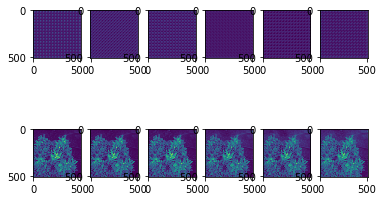

 22%|██▏       | 99/450 [02:55<08:13,  1.41s/it]

mrae[0.300]


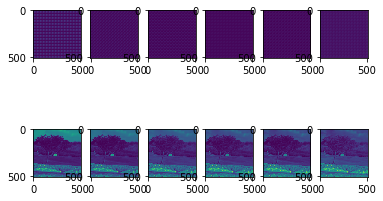

 33%|███▎      | 149/450 [04:23<09:10,  1.83s/it]

mrae[0.210]


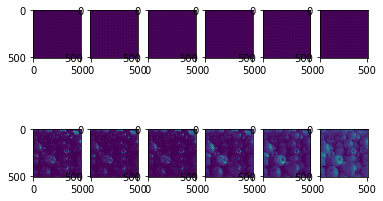

 44%|████▍     | 199/450 [06:00<07:36,  1.82s/it]

mrae[0.159]


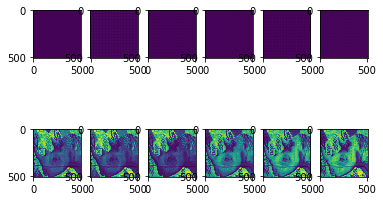

 55%|█████▌    | 249/450 [07:29<06:29,  1.94s/it]

mrae[0.128]


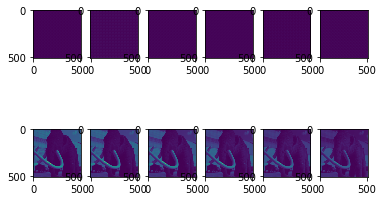

 66%|██████▋   | 299/450 [09:01<05:08,  2.04s/it]

mrae[0.108]


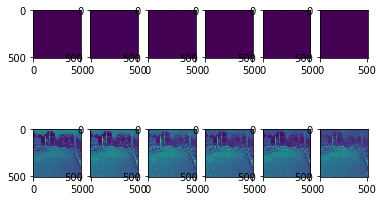

 78%|███████▊  | 349/450 [10:41<02:50,  1.69s/it]

mrae[0.093]


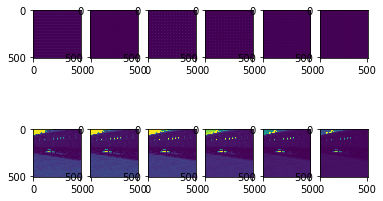

 89%|████████▊ | 399/450 [12:08<01:26,  1.69s/it]

mrae[0.082]


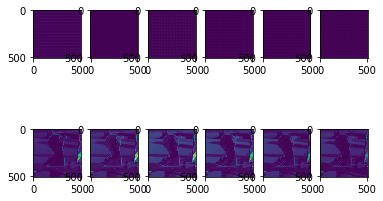

100%|█████████▉| 449/450 [13:35<00:01,  1.80s/it]

mrae[0.073]


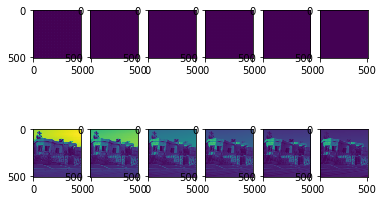

  0%|          | 0/450 [00:00<?, ?it/s]

d1[0.004] d2[0.012] g[0.197]
Epoch  2 / 5


 11%|█         | 49/450 [01:36<13:15,  1.98s/it]

mrae[0.037]


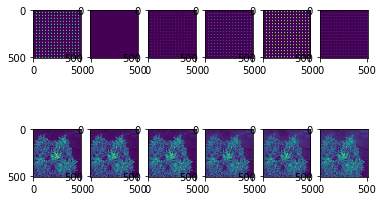

 22%|██▏       | 99/450 [02:59<07:23,  1.26s/it]

mrae[0.034]


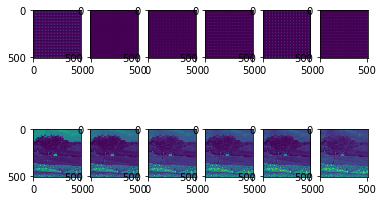

 33%|███▎      | 149/450 [04:27<09:30,  1.90s/it]

mrae[0.028]


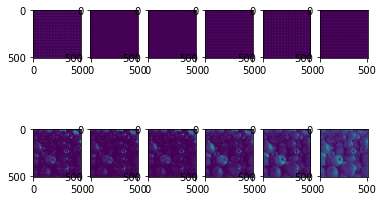

 44%|████▍     | 199/450 [05:58<08:10,  1.95s/it]

mrae[0.023]


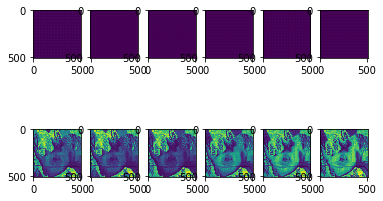

 55%|█████▌    | 249/450 [07:24<04:59,  1.49s/it]

mrae[0.019]


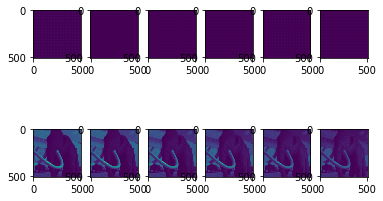

 66%|██████▋   | 299/450 [08:59<04:20,  1.72s/it]

mrae[0.017]


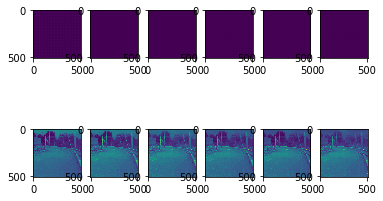

 78%|███████▊  | 349/450 [10:29<03:05,  1.84s/it]

mrae[0.015]


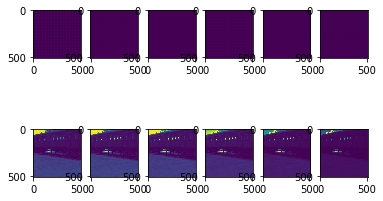

 89%|████████▊ | 399/450 [12:10<02:01,  2.38s/it]

mrae[0.014]


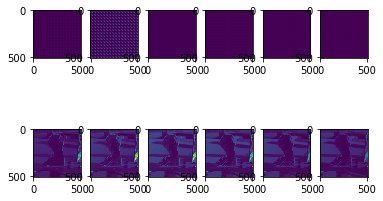

100%|█████████▉| 449/450 [13:35<00:01,  1.64s/it]

mrae[0.015]


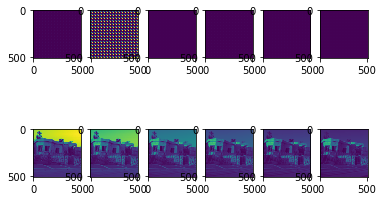

  0%|          | 0/450 [00:00<?, ?it/s]

d1[0.000] d2[0.001] g[2.150]
Epoch  3 / 5


 11%|█         | 49/450 [01:36<12:26,  1.86s/it]

mrae[0.019]


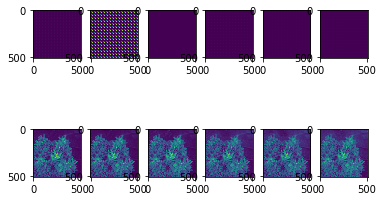

 22%|██▏       | 99/450 [03:15<08:04,  1.38s/it]

mrae[0.017]


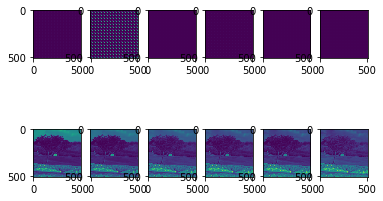

 33%|███▎      | 149/450 [04:39<08:20,  1.66s/it]

mrae[0.016]


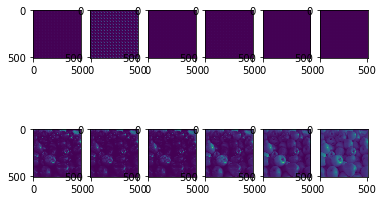

 44%|████▍     | 199/450 [06:10<06:29,  1.55s/it]

mrae[0.017]


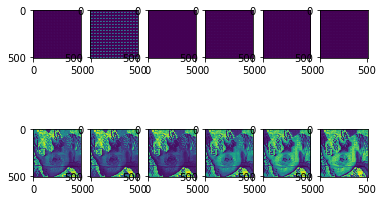

 55%|█████▌    | 249/450 [07:49<05:49,  1.74s/it]

mrae[0.017]


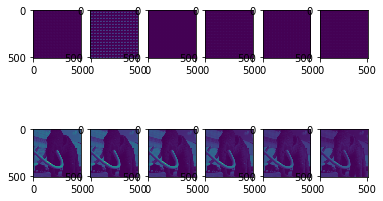

 66%|██████▋   | 299/450 [09:15<04:29,  1.78s/it]

mrae[0.017]


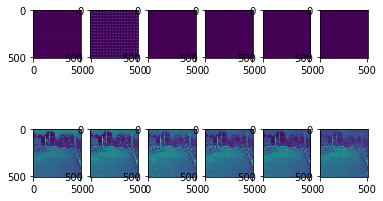

 78%|███████▊  | 349/450 [10:42<03:15,  1.93s/it]

mrae[0.017]


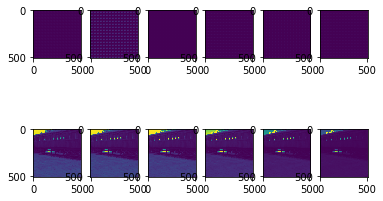

 89%|████████▊ | 399/450 [12:21<02:36,  3.08s/it]

mrae[0.017]


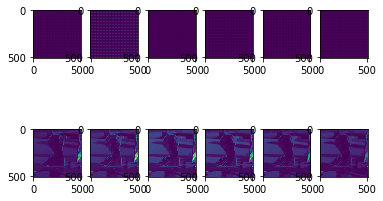

100%|█████████▉| 449/450 [13:59<00:01,  1.69s/it]

mrae[0.016]


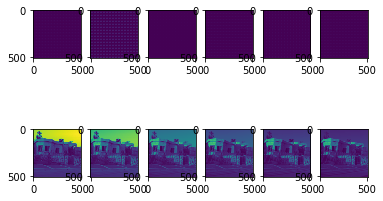

  0%|          | 0/450 [00:00<?, ?it/s]

d1[0.000] d2[0.000] g[1.164]
Epoch  4 / 5


 11%|█         | 49/450 [01:38<14:31,  2.17s/it]

mrae[0.012]


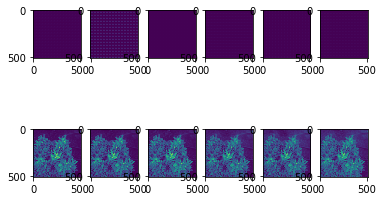

 22%|██▏       | 99/450 [03:04<10:44,  1.84s/it]

mrae[0.011]


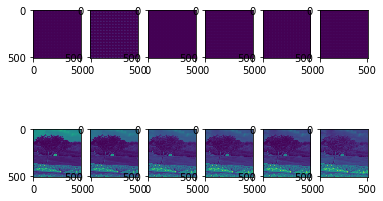

 33%|███▎      | 149/450 [04:44<10:08,  2.02s/it]

mrae[0.009]


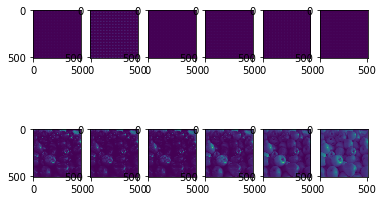

 44%|████▍     | 199/450 [06:18<08:04,  1.93s/it]

mrae[0.013]


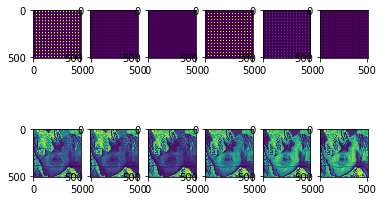

 55%|█████▌    | 249/450 [07:54<07:07,  2.13s/it]

mrae[0.029]


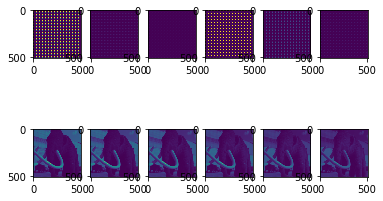

 66%|██████▋   | 299/450 [09:37<04:53,  1.95s/it]

mrae[0.040]


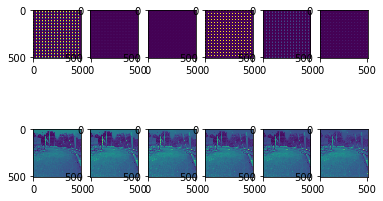

 78%|███████▊  | 349/450 [11:18<03:00,  1.79s/it]

mrae[0.046]


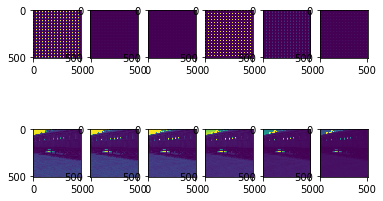

 89%|████████▊ | 399/450 [12:53<01:37,  1.91s/it]

mrae[0.049]


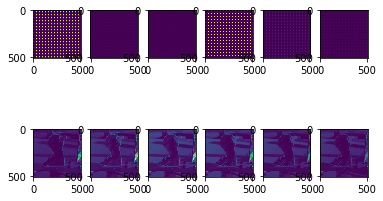

100%|█████████▉| 449/450 [14:34<00:02,  2.03s/it]

mrae[0.051]


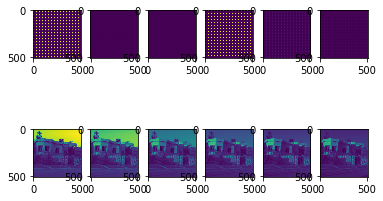

  0%|          | 0/450 [00:00<?, ?it/s]

d1[0.000] d2[0.000] g[8.158]
Epoch  5 / 5


 11%|█         | 49/450 [01:25<10:18,  1.54s/it]

mrae[0.066]


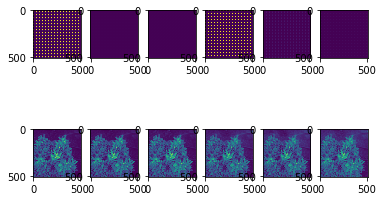

 22%|██▏       | 99/450 [02:55<09:29,  1.62s/it]

mrae[0.065]


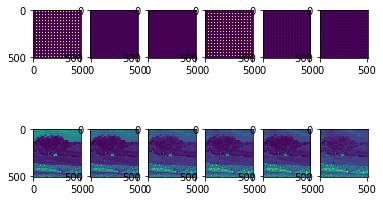

 33%|███▎      | 149/450 [04:24<08:09,  1.63s/it]

mrae[0.059]


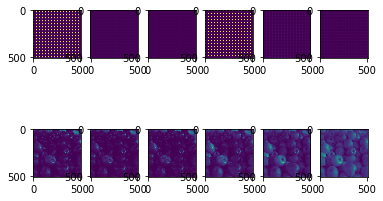

 44%|████▍     | 199/450 [05:54<07:00,  1.67s/it]

mrae[0.052]


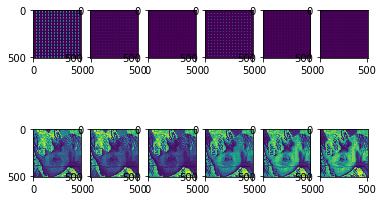

 55%|█████▌    | 249/450 [07:30<06:11,  1.85s/it]

mrae[0.047]


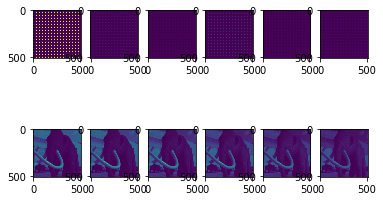

 66%|██████▋   | 299/450 [09:35<09:44,  3.87s/it]

mrae[0.043]


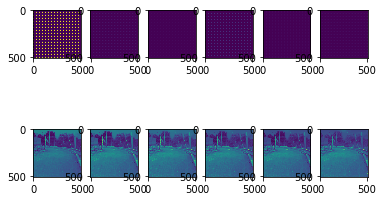

 78%|███████▊  | 349/450 [11:37<03:13,  1.91s/it]

mrae[0.040]


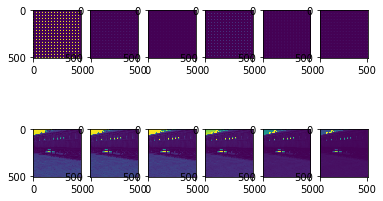

 89%|████████▊ | 399/450 [13:09<01:36,  1.89s/it]

mrae[0.037]


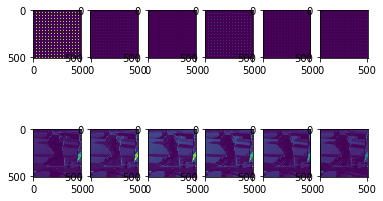

100%|█████████▉| 449/450 [14:50<00:01,  1.63s/it]

mrae[0.035]


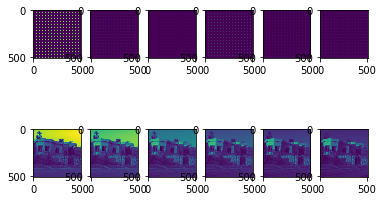

100%|██████████| 450/450 [14:53<00:00,  2.05s/it]

d1[0.000] d2[0.001] g[1.388]


In [9]:
patch_gan.train(X_dir = '/home/soham/leadingindia/dataset/NTIRE2020_Train_Clean',y_dir = '/home/soham/leadingindia/dataset/NTIRE2020_Spectral',epochs=5,batch_size=1)

In [ ]:
print('%.3f'%(11.22222222))

In [ ]:
generator = patch_gan.make_generator()

In [ ]:
generator.summary()

In [ ]:
discriminator = patch_gan.make_discriminator()

In [ ]:
discriminator.summary()

In [ ]:
unet_generator = patch_gan.UNet_Generator()

In [ ]:
unet_generator.summary()

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
import pydot

In [ ]:
data_loader = data_utils(X_dir='/home/soham/leadingindia/dataset/NTIRE2020_Train_Clean',y_dir = '/home/soham/leadingindia/dataset/NTIRE2020_Spectral')
rgb,spec = data_loader.load_data_batch(batch_size=1,batch_num=1,make_patch=False)
plt.imshow(rgb.reshape(rgb.shape[1:]))
plt.show()
plt.imshow(spec[0,:,:,1])
plt.show()

In [ ]:
spec[0,:,:,1].shape

In [ ]:
f, axarr = plt.subplots(2,4)
axarr[0,0].imshow(rgb[0])
axarr[0,1].imshow(spec[0,:,:,2])
axarr[0,2].imshow(spec[0,:,:,7])
axarr[0,3].imshow(spec[0,:,:,12])
axarr[1,0].imshow(spec[0,:,:,17])
axarr[1,1].imshow(spec[0,:,:,22])
axarr[1,2].imshow(spec[0,:,:,27])
axarr[1,3].imshow(spec[0,:,:,25])
plt.show()